## Set up Spark Environment

In [75]:
from pyspark.sql import SparkSession

In [76]:
## local pyspakr session
spark = SparkSession.builder \
   .master("local") \
   .appName("Predicting Fire Dept Calls") \
   .config("spark.executor.memory", "6gb") \
   .getOrCreate()

In [77]:
spark

In [78]:
## read files into spark environment
df = spark.read.format('com.databricks.spark.csv')\
                    .options(header='true', inferschema='true')\
                    .load('Fire_Department_Calls_for_Service.csv')


In [79]:
df.show(2)

+-----------+-------+---------------+----------------+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+----+-------------------+---------+------------+----+-----------------+--------+--------------+--------+---------------+----------------+---------+------------------------------+------------------------+-------------------+------------------------------------+--------------------+-------------+
|Call Number|Unit ID|Incident Number|       Call Type| Call Date|Watch Date|       Received DtTm|          Entry DtTm|       Dispatch DtTm|       Response DtTm|       On Scene DtTm|      Transport DtTm|       Hospital DtTm|Call Final Disposition|      Available DtTm|             Address|City|Zipcode of Incident|Battalion|Station Area| Box|Original Priority|Priority|Final Priority|ALS Unit|Call Type Group|Number o

## Data Frame show

In [80]:
## show first two rows of columns of 'Call Number' & 'unit id'
df.select('Call Number', 'unit id').show(2)

+-----------+-------+
|Call Number|unit id|
+-----------+-------+
|    1030101|    E18|
|    1030104|    M14|
+-----------+-------+
only showing top 2 rows



In [81]:
## show distinct name of 'Call Type Group' column from df
df.select('Call Type Group').distinct().show()

+--------------------+
|     Call Type Group|
+--------------------+
|               Alarm|
|                null|
|Potentially Life-...|
|Non Life-threatening|
|                Fire|
+--------------------+



## Groupby of Data Frame

In [82]:
df.groupBy('Call Type Group').count().show()

+--------------------+-------+
|     Call Type Group|  count|
+--------------------+-------+
|               Alarm| 483641|
|                null|2804570|
|Potentially Life-...| 985118|
|Non Life-threatening| 474821|
|                Fire|  83745|
+--------------------+-------+



In [83]:
df2 = df.groupBy('Call Type Group').count()
print(type(df2))
print(df2)

<class 'pyspark.sql.dataframe.DataFrame'>
DataFrame[Call Type Group: string, count: bigint]


In [84]:
## convert to Pandas DataFrame from Pyspark DataFrame
graphDF = df2.toPandas()
graphDF2 = graphDF.sort_values('count', ascending=False)

In [85]:
print(type(graphDF2))
print(graphDF2)

<class 'pandas.core.frame.DataFrame'>
                Call Type Group    count
1                          None  2804570
2  Potentially Life-Threatening   985118
0                         Alarm   483641
3          Non Life-threatening   474821
4                          Fire    83745


## Plot of group by of Call Type Group

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

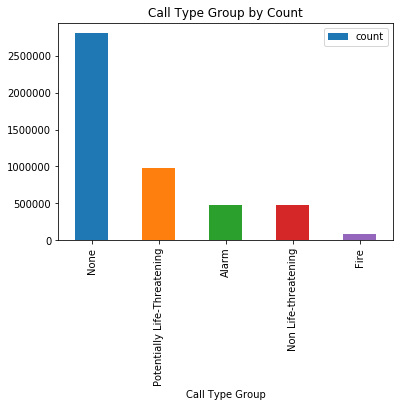

In [87]:
## Data Visualization
graphDF2.plot(x='Call Type Group', y = 'count', kind='bar')
plt.title('Call Type Group by Count')
plt.show()

In [88]:
df.groupBy('Call Type').count().orderBy('count', ascending=False).show(100)

+--------------------+-------+
|           Call Type|  count|
+--------------------+-------+
|    Medical Incident|3140351|
|      Structure Fire| 629222|
|              Alarms| 518236|
|   Traffic Collision| 198279|
|               Other|  77187|
|Citizen Assist / ...|  72630|
|        Outside Fire|  57283|
|        Vehicle Fire|  23242|
|        Water Rescue|  23062|
|Gas Leak (Natural...|  18438|
|   Electrical Hazard|  13604|
|Elevator / Escala...|  12745|
|Odor (Strange / U...|  12475|
|Smoke Investigati...|  10755|
|          Fuel Spill|   5597|
|              HazMat|   3934|
|Industrial Accidents|   2844|
|           Explosion|   2587|
|  Aircraft Emergency|   1511|
|       Assist Police|   1335|
|Train / Rail Inci...|   1278|
|   High Angle Rescue|   1172|
|Watercraft in Dis...|    913|
|Extrication / Ent...|    714|
|           Oil Spill|    516|
|Confined Space / ...|    515|
|Mutual Aid / Assi...|    471|
|         Marine Fire|    371|
|  Suspicious Package|    327|
|      A

## Data Preparation on condition of "Fire" Indicator

In [89]:
from pyspark.sql import functions as F
print(type(df))
print(df.select("Call Type").show(10))

## FireIndicator column
fireIndicator = df.select(df["Call Type"],F.when(df["Call Type"].like("%Fire%"),1).otherwise(0))
#print("Length of fire Indicator: ", fireIndicator.shape())
print("Type of fire Indicator: ", type(fireIndicator))
fireIndicator.show(10)
fireIndicator2 = fireIndicator.\
                withColumnRenamed('CASE WHEN Call Type LIKE %Fire% THEN 1 ELSE 0 END', 'Fire Indicator')
fireIndicator2.show()

<class 'pyspark.sql.dataframe.DataFrame'>
+--------------------+
|           Call Type|
+--------------------+
|    Medical Incident|
|    Medical Incident|
|    Medical Incident|
|              Alarms|
|    Medical Incident|
|Citizen Assist / ...|
|   Electrical Hazard|
|Odor (Strange / U...|
|    Medical Incident|
|    Medical Incident|
+--------------------+
only showing top 10 rows

None
Type of fire Indicator:  <class 'pyspark.sql.dataframe.DataFrame'>
+--------------------+-------------------------------------------------+
|           Call Type|CASE WHEN Call Type LIKE %Fire% THEN 1 ELSE 0 END|
+--------------------+-------------------------------------------------+
|    Medical Incident|                                                0|
|    Medical Incident|                                                0|
|    Medical Incident|                                                0|
|              Alarms|                                                0|
|    Medical Incident|     

In [90]:
fireIndicator2.groupBy('Fire Indicator').count().show()

+--------------+-------+
|Fire Indicator|  count|
+--------------+-------+
|             1| 710141|
|             0|4121754|
+--------------+-------+



In [91]:
## Add "fireIndicator" column
df3 = df.withColumn("fireIndicator", F.when(df["Call Type"].like("%Fire%"),1).otherwise(0))

In [92]:
df3.printSchema()

root
 |-- Call Number: integer (nullable = true)
 |-- Unit ID: string (nullable = true)
 |-- Incident Number: integer (nullable = true)
 |-- Call Type: string (nullable = true)
 |-- Call Date: string (nullable = true)
 |-- Watch Date: string (nullable = true)
 |-- Received DtTm: string (nullable = true)
 |-- Entry DtTm: string (nullable = true)
 |-- Dispatch DtTm: string (nullable = true)
 |-- Response DtTm: string (nullable = true)
 |-- On Scene DtTm: string (nullable = true)
 |-- Transport DtTm: string (nullable = true)
 |-- Hospital DtTm: string (nullable = true)
 |-- Call Final Disposition: string (nullable = true)
 |-- Available DtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode of Incident: integer (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- Station Area: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- Original Priority: string (nullable = true)
 |-- Priority: string (nullable

In [93]:
df3.select('Call Type', 'fireIndicator').show(20)

+--------------------+-------------+
|           Call Type|fireIndicator|
+--------------------+-------------+
|    Medical Incident|            0|
|    Medical Incident|            0|
|    Medical Incident|            0|
|              Alarms|            0|
|    Medical Incident|            0|
|Citizen Assist / ...|            0|
|   Electrical Hazard|            0|
|Odor (Strange / U...|            0|
|    Medical Incident|            0|
|    Medical Incident|            0|
|              Alarms|            0|
|    Medical Incident|            0|
|    Medical Incident|            0|
|    Medical Incident|            0|
|              Alarms|            0|
|              Alarms|            0|
|    Medical Incident|            0|
|               Other|            0|
|    Medical Incident|            0|
|      Structure Fire|            1|
+--------------------+-------------+
only showing top 20 rows



In [94]:
## Subset the variables for analysis
df4 = df3.select('fireIndicator', 
               'Zipcode of Incident',
               'Battalion',
               'Station Area',
               'Box', 
               'Number of Alarms',
               'Unit sequence in call dispatch',
               'Neighborhooods - Analysis Boundaries',
               'Fire Prevention District',
               'Supervisor District',
               'final priority')
df4.show()

+-------------+-------------------+---------+------------+----+----------------+------------------------------+------------------------------------+------------------------+-------------------+--------------+
|fireIndicator|Zipcode of Incident|Battalion|Station Area| Box|Number of Alarms|Unit sequence in call dispatch|Neighborhooods - Analysis Boundaries|Fire Prevention District|Supervisor District|final priority|
+-------------+-------------------+---------+------------+----+----------------+------------------------------+------------------------------------+------------------------+-------------------+--------------+
|            0|              94116|      B08|          18|0757|               1|                             1|                     Sunset/Parkside|                       8|                  4|             3|
|            0|              94122|      B08|          23|7651|               1|                             2|                     Sunset/Parkside|                

In [95]:
print('Total Rows')
print(type(df4))
df4.count()

Total Rows
<class 'pyspark.sql.dataframe.DataFrame'>


4831895

In [96]:
print('Rows without Null values')
df4.dropna().count()

Rows without Null values


4815148

In [97]:
print('Row with Null Values')
df4.count()-df4.dropna().count()

Row with Null Values


16747

In [98]:
## Remove missing values
df5 = df4.dropna()

In [99]:
df5.groupBy('fireIndicator').count().orderBy('count', ascending = False).show()

+-------------+-------+
|fireIndicator|  count|
+-------------+-------+
|            0|4106120|
|            1| 709028|
+-------------+-------+



In [104]:
df5.columns

['fireIndicator',
 'Zipcode of Incident',
 'Battalion',
 'Station Area',
 'Box',
 'Number of Alarms',
 'Unit sequence in call dispatch',
 'Neighborhooods - Analysis Boundaries',
 'Fire Prevention District',
 'Supervisor District',
 'final priority']

## Feature Enginering of PySpark

In [100]:
## import pyspark feature engineering to assign numeric values to categorical variable 
from pyspark.ml.feature import StringIndexer

In [101]:
## StringIndexer encodes a string column of labels to a column of labeled indices. 
## Define each indexer algorithm
Neighborhoods_indexer = StringIndexer(inputCol='Neighborhooods - Analysis Boundaries', outputCol='Neighbors')
zip_indexer = StringIndexer(inputCol='Zipcode of Incident', outputCol='Zip')
batallion_indexer = StringIndexer(inputCol='Battalion', outputCol='Battalion_')
stationarea_indexer = StringIndexer(inputCol='Station Area', outputCol='StationArea')
box_indexer = StringIndexer(inputCol='Box', outputCol='Box_')
fireDistrict_indexer = StringIndexer(inputCol='Fire Prevention District', outputCol='FireDistrict')
supervisorDistrict_indexer = StringIndexer(inputCol='Supervisor District', outputCol='SupervisorDistrict')

In [102]:
print(type(Neighborhoods_indexer))
print(Neighborhoods_indexer)

<class 'pyspark.ml.feature.StringIndexer'>
StringIndexer_175083e2337a


In [103]:
## Create a model for each feature
Neighborhoods_indexer_model = Neighborhoods_indexer.fit(df5)
zip_indexer_model  = zip_indexer.fit(df5)
batallion_indexer_model  = batallion_indexer.fit(df5)
stationarea_indexer_model  = stationarea_indexer.fit(df5)
box_indexer_model  = box_indexer.fit(df5)
fireDistrict_model  = fireDistrict_indexer.fit(df5)
supervisorDistrict_model  = supervisorDistrict_indexer.fit(df5)

In [105]:
print(Neighborhoods_indexer_model)
print(type(Neighborhoods_indexer_model))

StringIndexer_175083e2337a
<class 'pyspark.ml.feature.StringIndexerModel'>


In [106]:
## Transform (create feature) using models
df5 = Neighborhoods_indexer_model.transform(df5)
df5 = zip_indexer_model.transform(df5)
df5 = batallion_indexer_model.transform(df5)
df5 = stationarea_indexer_model.transform(df5)
df5 = box_indexer_model.transform(df5)
df5 = fireDistrict_model.transform(df5)
df5 = supervisorDistrict_model.transform(df5)

In [107]:
df5.columns

['fireIndicator',
 'Zipcode of Incident',
 'Battalion',
 'Station Area',
 'Box',
 'Number of Alarms',
 'Unit sequence in call dispatch',
 'Neighborhooods - Analysis Boundaries',
 'Fire Prevention District',
 'Supervisor District',
 'final priority',
 'Neighbors',
 'Zip',
 'Battalion_',
 'StationArea',
 'Box_',
 'FireDistrict',
 'SupervisorDistrict']

In [109]:
## show how variable is converted into features. 
df5.select('Neighborhooods - Analysis Boundaries', 'Neighbors').show()

+------------------------------------+---------+
|Neighborhooods - Analysis Boundaries|Neighbors|
+------------------------------------+---------+
|                     Sunset/Parkside|      5.0|
|                     Sunset/Parkside|      5.0|
|                          Tenderloin|      0.0|
|                          Tenderloin|      0.0|
|                Financial Distric...|      3.0|
|                            Nob Hill|      7.0|
|                            Nob Hill|      7.0|
|                       Outer Mission|     22.0|
|                Bayview Hunters P...|      4.0|
|                           Chinatown|     13.0|
|                     Sunset/Parkside|      5.0|
|                             Mission|      2.0|
|                         Mission Bay|     28.0|
|                    Western Addition|      6.0|
|                    Western Addition|      6.0|
|                     Sunset/Parkside|      5.0|
|                  West of Twin Peaks|     11.0|
|                   

In [110]:
## Select features only
df6 = df5.select('fireIndicator',\
          'Neighbors',\
          'Zip',\
          'Battalion_',\
          'StationArea',\
          'Box_',\
          'Number Of Alarms',\
          'Unit sequence in call dispatch',\
          'FireDistrict',\
          'SupervisorDistrict',\
          'final priority')

In [114]:
df6.show(2)

+-------------+---------+----+----------+-----------+------+----------------+------------------------------+------------+------------------+--------------+
|fireIndicator|Neighbors| Zip|Battalion_|StationArea|  Box_|Number Of Alarms|Unit sequence in call dispatch|FireDistrict|SupervisorDistrict|final priority|
+-------------+---------+----+----------+-----------+------+----------------+------------------------------+------------+------------------+--------------+
|            0|      5.0|18.0|       5.0|       29.0|1737.0|               1|                             1|         7.0|              10.0|             3|
|            0|      5.0| 8.0|       5.0|       31.0|1284.0|               1|                             2|         7.0|              10.0|             3|
+-------------+---------+----+----------+-----------+------+----------------+------------------------------+------------+------------------+--------------+
only showing top 2 rows



In [111]:
df6.printSchema()

root
 |-- fireIndicator: integer (nullable = false)
 |-- Neighbors: double (nullable = false)
 |-- Zip: double (nullable = false)
 |-- Battalion_: double (nullable = false)
 |-- StationArea: double (nullable = false)
 |-- Box_: double (nullable = false)
 |-- Number Of Alarms: integer (nullable = true)
 |-- Unit sequence in call dispatch: integer (nullable = true)
 |-- FireDistrict: double (nullable = false)
 |-- SupervisorDistrict: double (nullable = false)
 |-- final priority: integer (nullable = true)



In [115]:
features = ['Neighbors',
 'Zip',
 'Battalion_',
 'StationArea',
 'Box_',
 'Number Of Alarms',
 'Unit sequence in call dispatch',
 'FireDistrict',
 'SupervisorDistrict',
 'final priority']

In [116]:
from pyspark.ml.feature import VectorAssembler

feature_vectors = VectorAssembler(
        inputCols = features,
        outputCol = "features")

In [118]:
type(feature_vectors)

pyspark.ml.feature.VectorAssembler

In [119]:
df7 = feature_vectors.transform(df6)

In [120]:
df7.columns

['fireIndicator',
 'Neighbors',
 'Zip',
 'Battalion_',
 'StationArea',
 'Box_',
 'Number Of Alarms',
 'Unit sequence in call dispatch',
 'FireDistrict',
 'SupervisorDistrict',
 'final priority',
 'features']

In [127]:
print(df7.select('features').take(1))

[Row(features=DenseVector([5.0, 18.0, 5.0, 29.0, 1737.0, 1.0, 1.0, 7.0, 10.0, 3.0]))]


In [130]:
## drop other variables except "fireIndicator" & "features"
df8 = df7.drop("Neighbors",
 "Zip",
 "Battalion_",
 "StationArea",
 "Box_",
 "Number Of Alarms",
 "Unit sequence in call dispatch",
 "FireDistrict",
 "SupervisorDistrict",
 "final priority")

In [131]:
## changes name of column
df8 = df8.withColumnRenamed('fireIndicator', 'label')

In [132]:
df8.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[5.0,18.0,5.0,29....|
|    0|[5.0,8.0,5.0,31.0...|
|    0|[0.0,0.0,1.0,2.0,...|
|    0|(10,[4,5,6,7,9],[...|
|    0|[3.0,17.0,0.0,0.0...|
|    0|[7.0,3.0,2.0,1.0,...|
|    0|[7.0,3.0,3.0,17.0...|
|    0|[22.0,5.0,6.0,18....|
|    0|[4.0,4.0,4.0,7.0,...|
|    0|[13.0,21.0,2.0,4....|
|    0|[5.0,8.0,5.0,26.0...|
|    0|[2.0,2.0,7.0,3.0,...|
|    0|[28.0,7.0,0.0,8.0...|
|    0|[6.0,6.0,3.0,6.0,...|
|    0|[6.0,6.0,3.0,6.0,...|
|    0|[5.0,18.0,5.0,29....|
|    0|[11.0,22.0,5.0,37...|
|    0|[27.0,11.0,8.0,13...|
|    1|[23.0,5.0,6.0,21....|
|    0|[1.0,1.0,1.0,2.0,...|
+-----+--------------------+
only showing top 20 rows



In [133]:
## Prepare test and training data
(trainDF, testDF) = df8.randomSplit([0.75, 0.25], seed = 12345)

In [134]:
print(trainDF.count())
print(testDF.count())

3611539
1203609


In [ ]:
## Import Pyspark classification algorithm
from pyspark.ml.classification import LogisticRegression

## Create instance of ML Logistic Regression using label and features
logreg = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

## Train the model
LogisticRegressionModel = logreg.fit(trainDF)

In [ ]:
print(logreg)
print(LogisticRegressionModel)

In [136]:
## Prediction using the trained model
df_predicted = LogisticRegressionModel.transform(testDF)

In [137]:
df_predicted.printSchema()

root
 |-- label: integer (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [139]:
type(df_predicted)

pyspark.sql.dataframe.DataFrame

In [138]:
df_predicted.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(10,[2,4,5,6,9],[...|[3.39109577466871...|[0.96742509438895...|       0.0|
|    0|(10,[2,4,5,6,9],[...|[1.38359453477156...|[0.79956767788848...|       0.0|
|    0|(10,[2,4,5,6,9],[...|[0.89393993774874...|[0.70970256774538...|       0.0|
|    0|(10,[2,4,5,6,9],[...|[3.38623260579572...|[0.96727148868075...|       0.0|
|    0|(10,[2,4,5,6,9],[...|[3.38623260579572...|[0.96727148868075...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [140]:
df_predicted.select('features').take(1)

[Row(features=SparseVector(10, {2: 1.0, 4: 3.0, 5: 1.0, 6: 1.0, 9: 2.0}))]

In [141]:
df_predicted.select('rawPrediction').take(1)

[Row(rawPrediction=DenseVector([3.3911, -3.3911]))]

In [142]:
df_predicted.select('probability').take(1)

[Row(probability=DenseVector([0.9674, 0.0326]))]

In [143]:
df_predicted.crosstab('label', 'prediction').show()

+----------------+-------+-----+
|label_prediction|    0.0|  1.0|
+----------------+-------+-----+
|               1| 127121|50104|
|               0|1016260|10124|
+----------------+-------+-----+



In [145]:
from sklearn import metrics

In [146]:
actual = df_predicted.select('label').toPandas()

In [147]:
predicted = df_predicted.select('prediction').toPandas()

In [148]:
metrics.accuracy_score(actual, predicted)

0.8859721055591974

In [149]:
df_predicted.groupBy('label').count().show()

+-----+-------+
|label|  count|
+-----+-------+
|    1| 177225|
|    0|1026384|
+-----+-------+



In [150]:
df_predicted.describe('label').show()

+-------+-------------------+
|summary|              label|
+-------+-------------------+
|  count|            1203609|
|   mean|0.14724466167999742|
| stddev| 0.3543497927323642|
|    min|                  0|
|    max|                  1|
+-------+-------------------+

